# Test TFRecord randomization
Testing TFRecord randomization over shards with the interleave function using a dummy dataset

In [9]:
import tensorflow as tf
tf.enable_eager_execution()

import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib import gridspec
from pprint import pprint
from glob import glob
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from itertools import repeat
from collections import Counter
import re
import os

In [103]:
%matplotlib inline
fig_width = 16
fig_height = 12
def visualize_dataset(dataset, show_plot=True, aspect_ratio=8):
    #iterator = dataset.make_one_shot_iterator()
    #el = iterator.get_next()
    all_batches = []
    n_cols = 0
    n_rows = 0
    for x in dataset:
        print(x)
        all_batches.append(x)
        n_cols = np.max([n_cols, np.max(x)])
        n_rows += 1

    mat = np.zeros(shape = (n_rows, n_cols+1))
  
    for row, single_batch in enumerate(all_batches):
        mat[row, single_batch] += 1

    if show_plot:
        plt.figure(figsize=(fig_width, fig_height))
        plt.imshow(mat, aspect=aspect_ratio, cmap='gray_r')
        plt.xlabel('Sample index')
        plt.ylabel('Batch index')
        plt.show() 

950
tf.Tensor(
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99], shape=(100,), dtype=int64)
tf.Tensor(
[100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153
 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171
 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 196 197 198 199], shape=(100,), dtype=int64)
tf.Tensor(
[200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235
 236 237 238 239 240 241 242 243 244 245 246 247

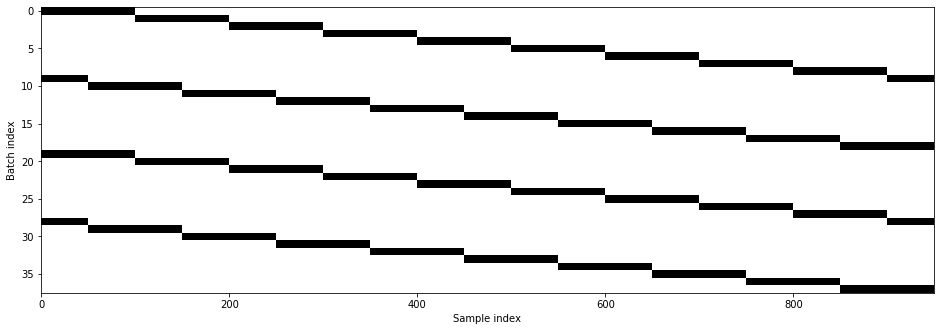

In [159]:
Nsamples = 950#(41+72+78)*25
print(Nsamples)
batch_size = 100
nr_epochs = 4


dataset = tf.data.Dataset.range(Nsamples)
# We repeat the dataset nr_epoch times.
dataset = dataset.repeat(nr_epochs)
dataset = dataset.batch(batch_size=batch_size)

visualize_dataset(dataset)

In [160]:
class TFRecordGenerator(object):
    def __init__(self, num_shards=10):
        self.num_shards = num_shards

    def _pick_output_shard(self):
        return random.randint(0, self.num_shards-1)
    
    @staticmethod
    def generate_records_per_batch(dataset, num_samples, tfrecord_file_name):
        ''' Creates x TFRecords, where each records aims to hold num_samples 
        
        '''
        writers = []
        options = tf.io.TFRecordOptions(tf.compat.v1.python_io.TFRecordCompressionType.GZIP)

        writers.append(tf.io.TFRecordWriter("{}-{}.gz".format(tfrecord_file_name, 0), options))  
        
        counter = 0   
        file_incr = 1
        record_incr = 0
        for index in range(dataset):
            # Open and write a new tfrecord file
            if record_incr == num_samples:
                writers.append(tf.io.TFRecordWriter("{}-{}.gz".format(tfrecord_file_name, file_incr), options))
                file_incr +=1
                record_incr = 0
                
            example = tf.train.Example(features = tf.train.Features(feature = {
                'index': tf.train.Feature(int64_list = tf.train.Int64List(value = [index])),
            }))
            writers[-1].write(example.SerializeToString())
            counter += 1
            record_incr +=1
            
            # status report
            if index % 5 == 0:
                print("Currently at index {}".format(index))

        # Close all files
        for w in writers:
            w.close()
        print("%d records writen" % counter)
    
# Standalone function to parse a serialized example record into an index.
def _parse_tfexample_fn(tfrecord, mode=None):
    # Extract features using the keys set during creation
    features = {'index': tf.FixedLenFeature([], tf.int64) }
    # Extract the data record
    sample = tf.parse_single_example(tfrecord, features)
    # And extract the scalar sample index from the dict.
    index = sample['index']
    return index



In [161]:
t = TFRecordGenerator(num_shards = 10)
t.generate_records_per_batch(dataset = Nsamples, num_samples=100, tfrecord_file_name= os.path.join('data', 'rng','record'))

Currently at index 0
Currently at index 5
Currently at index 10
Currently at index 15
Currently at index 20
Currently at index 25
Currently at index 30
Currently at index 35
Currently at index 40
Currently at index 45
Currently at index 50
Currently at index 55
Currently at index 60
Currently at index 65
Currently at index 70
Currently at index 75
Currently at index 80
Currently at index 85
Currently at index 90
Currently at index 95
Currently at index 100
Currently at index 105
Currently at index 110
Currently at index 115
Currently at index 120
Currently at index 125
Currently at index 130
Currently at index 135
Currently at index 140
Currently at index 145
Currently at index 150
Currently at index 155
Currently at index 160
Currently at index 165
Currently at index 170
Currently at index 175
Currently at index 180
Currently at index 185
Currently at index 190
Currently at index 195
Currently at index 200
Currently at index 205
Currently at index 210
Currently at index 215
Currently 

['./data/rng/record-0.gz', './data/rng/record-1.gz', './data/rng/record-2.gz', './data/rng/record-3.gz', './data/rng/record-4.gz', './data/rng/record-5.gz', './data/rng/record-6.gz', './data/rng/record-7.gz', './data/rng/record-8.gz', './data/rng/record-9.gz']
tf.Tensor([700 500 300 100 400 800 600 900   0 200], shape=(10,), dtype=int64)
tf.Tensor([701 501 301 101 401 801 601 901   1 201], shape=(10,), dtype=int64)
tf.Tensor([702 502 302 102 402 802 602 902   2 202], shape=(10,), dtype=int64)
tf.Tensor([703 503 303 103 403 803 603 903   3 203], shape=(10,), dtype=int64)
tf.Tensor([704 504 304 104 404 804 604 904   4 204], shape=(10,), dtype=int64)
tf.Tensor([705 505 305 105 405 805 605 905   5 205], shape=(10,), dtype=int64)
tf.Tensor([706 506 306 106 406 806 606 906   6 206], shape=(10,), dtype=int64)
tf.Tensor([707 507 307 107 407 807 607 907   7 207], shape=(10,), dtype=int64)
tf.Tensor([708 508 308 108 408 808 608 908   8 208], shape=(10,), dtype=int64)
tf.Tensor([709 509 309 109 4

tf.Tensor([ 95 295 595 395 495 695 795 195  96 296], shape=(10,), dtype=int64)
tf.Tensor([596 396 496 696 796 196  97 297 597 397], shape=(10,), dtype=int64)
tf.Tensor([497 697 797 197  98 298 598 398 498 698], shape=(10,), dtype=int64)
tf.Tensor([798 198  99 299 599 399 499 699 799 199], shape=(10,), dtype=int64)


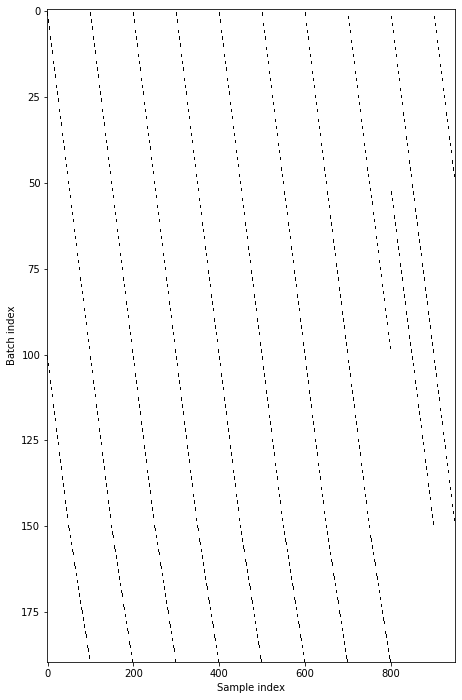

In [177]:
def random(file_names):
    files = tf.data.Dataset.list_files(file_names, shuffle=None, seed=None)
    shards = files.shuffle(buffer_size=1)
    
    #for x in shards:
    #    print(x)
    dataset = shards.interleave(lambda x: tf.data.TFRecordDataset(x, compression_type='GZIP'), 
                                cycle_length=190, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=1)
    dataset = dataset.repeat(4)
    dataset = dataset.map(_parse_tfexample_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(100)
    return dataset

filenames = glob('./data/rng/record*.gz')
print(filenames)

# First just list all file pathes to the sharded tfrecord dataset.
dataset = tf.data.TFRecordDataset.list_files(filenames)
# Make sure to fully shuffle the list of tfrecord files.
dataset = dataset.shuffle(buffer_size=100)

# Preprocesses 10 files concurrently and interleaves records from each file into a single, unified dataset.
dataset = dataset.interleave(
    lambda x: tf.data.TFRecordDataset(x, compression_type='GZIP'),
    cycle_length=10,
    block_length = 1,
    num_parallel_calls=1)
# Here we convert raw protobufs into a structs.
#dataset = dataset.shuffle(1000)
dataset = dataset.map(_parse_tfexample_fn, num_parallel_calls=2)
dataset = dataset.repeat(1)
dataset = dataset.batch(10)

#dataset = random(filenames)
visualize_dataset(dataset)

In [158]:
a = tf.data.Dataset.range(1, 6)  # ==> [ 1, 2, 3, 4, 5 ]

# NOTE: New lines indicate "block" boundaries.
a = a.interleave(lambda x: tf.data.Dataset.from_tensors(x).repeat(6),
            cycle_length=2, block_length=4)  # ==> [1, 1, 1, 1,
                                             #      2, 2, 2, 2,
                                             #      1, 1,
                                             #      2, 2,
                                             #      3, 3, 3, 3,
                                             #      4, 4, 4, 4,
                                             #      3, 3,
                                             #      4, 4,
                                             #      5, 5, 5, 5,
                                             #      5, 5]
for x in a:
    print(x)

tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype

['./data/rng/record-0.gz', './data/rng/record-1.gz', './data/rng/record-2.gz', './data/rng/record-3.gz', './data/rng/record-4.gz', './data/rng/record-5.gz', './data/rng/record-6.gz', './data/rng/record-7.gz', './data/rng/record-8.gz', './data/rng/record-9.gz']
tf.Tensor([900 901 902 903 904 905 906 907 908 909], shape=(10,), dtype=int64)
tf.Tensor([910 700 911 912 913 914 915 916 917 918], shape=(10,), dtype=int64)
tf.Tensor([919 920 921 922 923 924 925 926 927 928], shape=(10,), dtype=int64)
tf.Tensor([929   0 930 931 800 932 933 934 935 936], shape=(10,), dtype=int64)
tf.Tensor([937 938 939 300 940 941 942 943 944 945], shape=(10,), dtype=int64)
tf.Tensor([946 947 948 949 400   1 100 101   2 701], shape=(10,), dtype=int64)
tf.Tensor([801 802 401 702   3 600 102 200 803 804], shape=(10,), dtype=int64)
tf.Tensor([201 805 301   4   5 103 500 806 501 601], shape=(10,), dtype=int64)
tf.Tensor([202   6 203 502 602 703 807   7 104 402], shape=(10,), dtype=int64)
tf.Tensor([105 603 106 503 4

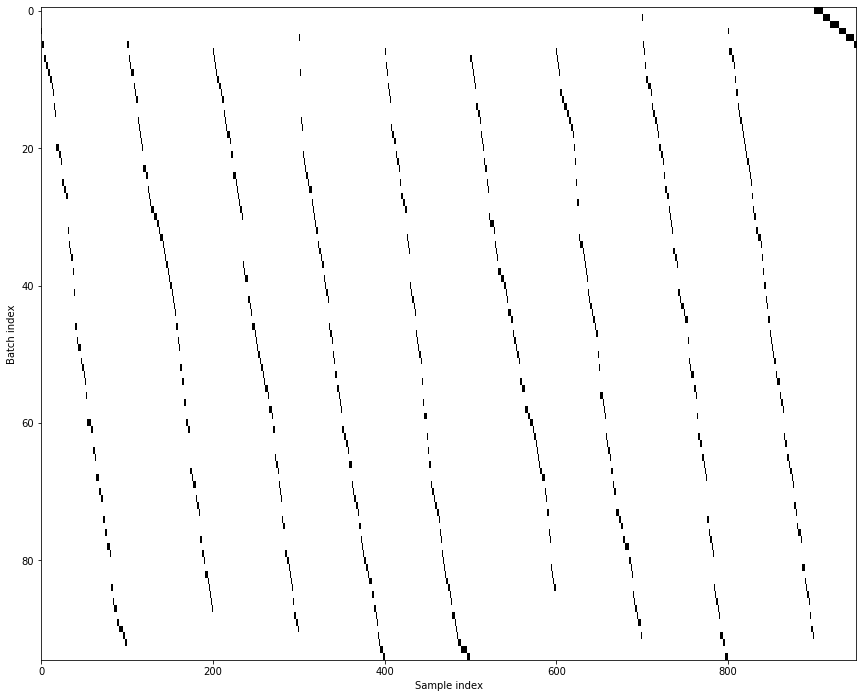

In [191]:
filenames = glob('./data/rng/record*.gz')
print(filenames)

# First just list all file pathes to the sharded tfrecord dataset.
dataset = tf.data.TFRecordDataset.list_files(filenames)
dataset = [tf.data.TFRecordDataset(x, compression_type='GZIP') for x in filenames]

# Preprocesses 10 files concurrently and interleaves records from each file into a single, unified dataset.
dataset = tf.compat.v1.data.experimental.sample_from_datasets(dataset,
    weights=[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.9],
    seed=None
)
# Here we convert raw protobufs into a structs.
#dataset = dataset.shuffle(1000)
dataset = dataset.map(_parse_tfexample_fn, num_parallel_calls=2)
dataset = dataset.repeat(1)
dataset = dataset.batch(10)

#dataset = random(filenames)
visualize_dataset(dataset)

In [180]:
tf.compat.v1.data.experimental.sample_from_datasets

<function tensorflow.python.data.experimental.ops.interleave_ops.sample_from_datasets_v1(datasets, weights=None, seed=None)>